In [1]:
import os
os.chdir('/ws/git_naturalness_influence/NEW')
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

from ni_dataset import MapInWild_Naturalness
from custom_unet import UNet
from pl_trainer import UNetSimple
from unetSE import UNet_SE

import albumentations as A
import numpy as np
import torch
from tqdm.auto import tqdm

from helpers import get_channels, stretch, cmap, convert_to_color_wc

import json
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable


%load_ext autoreload
%autoreload 2

Global seed set to 42
/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fname_pickle = "./modality_importance_values_nobn_yesseblock.json" 
bands = ("VV","VH","B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12","ESA_WC","VIIRS")

pickle_file = open(fname_pickle, "rb" )
band_importance = json.load(pickle_file)
occ_values = np.asarray(band_importance['occlusion_values'])
wdpa = np.asarray(band_importance['wdpa'])

wdpa_reshap = wdpa.reshape(-1)
occ_reshap = occ_values.reshape(-1,occ_values.shape[-1])
print("occ_reshap", occ_reshap.shape)
print("wdpa_reshap", wdpa_reshap.shape)

occ_reshap (96, 14)
wdpa_reshap (96,)


### Visualize a bar plot and images side by side

In [3]:
dataset_root = '/data/Dataset_'
split_file = '/data/aux_/split_IDs/tvt_split.csv'
subset_file = '/data/aux_/single_temporal_subset/single_temporal_subset.csv'
bands = ("VV","VH","B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12","2020_Map","avg_rad")
crop_size = (1920,1920)
batch_size = 32
device = "cuda"
checkpoint_path = "./unetsimple_checkpoints/last__bolu4_seloss_w_sigmoid_v3_16_256epoch=09-val_loss=0.14.ckpt"

test_transform = A.Compose([A.RandomCrop(crop_size[0], crop_size[1], p=1.0)])

test_dataset = MapInWild_Naturalness(split_file= split_file, root= dataset_root,split='test', 
                                bands= bands, subsetpath = subset_file, transforms=None)

model = UNetSimple(input_size=crop_size)

model = model.load_from_checkpoint(checkpoint_path= checkpoint_path,
                          map_location= device, input_size=crop_size)
model = model.eval()

UNET_SE:v
UNET_SE:v


In [8]:

def integer_decode(normalized_array):
    min_val = 10.0
    max_val = 100.0
    original_array = normalized_array * (max_val - min_val) + min_val
    return original_array

def get_data(idx):
    image_mask = test_dataset[idx]
    wdpa_id = image_mask[-1]
    input = torch.Tensor(np.expand_dims(image_mask[0], 0)).to(device)
    tabular = torch.zeros(1,14).to(device)

    logits_reg, patch_reg, factors = model.model.forward(input,tabular)
    patch_reg = patch_reg.detach().cpu().numpy()

    image = image_mask[0]
    gt_mask = image_mask[1]

    rgb_s2 = get_channels(im = image, all_channels = bands, select_channels = ['B4', 'B3', 'B2'])
    s1 = get_channels(im = image, all_channels = bands, select_channels = ['VH'])
    esa_wc = get_channels(im = image, all_channels = bands, select_channels = ['2020_Map'])
    viirs = get_channels(im = image, all_channels = bands, select_channels = ['avg_rad'])

    s2_im = stretch(np.transpose(rgb_s2.numpy(),(1,2,0)))

    gt_mask = gt_mask.squeeze()

    pr_mask = logits_reg.detach().cpu().numpy().squeeze()

    esa_wc_inteight= np.asarray(esa_wc, dtype='uint8')
    esa_color = convert_to_color_wc(esa_wc_inteight.squeeze())
    
    data = {"s2":s2_im,"s1":s1, "esa":esa_color, "gt":gt_mask, "pred":pr_mask, "viirs":viirs}
    return data

In [9]:
def viz_bar_images(idx, bar_vals, data, save=False):

    categories = ("VV","VH","B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12","LC","VIIRS")
    fig = plt.figure(figsize=(16, 8))

    gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 1])

    ax0 = plt.subplot(gs[:, 0])
    ax0.bar(categories, bar_vals, color='orange')
    ax0.set_title('')
    ax0.set_xlabel('Bands')
    ax0.set_ylabel('Attribution Value')
    ax0.set_xticks(np.arange(len(categories)))
    ax0.set_xticklabels(categories, rotation=45)
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_visible(False)

    ax1 = plt.subplot(gs[0, 1])
    im1 = ax1.imshow(data["s2"])
    ax1.axis('off')
    ax1.set_title('Sentinel-2')

    ax2 = plt.subplot(gs[0, 2])
    im2 = ax2.imshow(data["esa"])
    ax2.axis('off')
    ax2.set_title('ESA WorldCover')

    ax3 = plt.subplot(gs[0, 3])
    im3 = ax3.imshow(data["gt"] * 100, cmap=cmap, vmin=0, vmax=100, interpolation='none')
    ax3.axis('off')
    ax3.set_title('Annotation')

    ax4 = plt.subplot(gs[1, 1])
    im4 = ax4.imshow(data["s1"].squeeze())
    ax4.axis('off')
    ax4.set_title('Sentinel-1')

    ax5 = plt.subplot(gs[1, 2])
    im5 = ax5.imshow(data["viirs"].squeeze(), cmap='BuPu')
    ax5.axis('off')
    ax5.set_title('VIIRS-DNB')

    ax6 = plt.subplot(gs[1, 3])
    im6 = ax6.imshow(data["pred"] * 100, cmap=cmap, vmin=0, vmax=100, interpolation='none')
    ax6.axis('off')
    ax6.set_title('Prediction')

    divider5 = make_axes_locatable(ax5)
    cax5 = divider5.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im5, cax=cax5)

    divider6 = make_axes_locatable(ax6)
    cax6 = divider6.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im6, cax=cax6)

    plt.tight_layout()
    if save==True:
        plt.savefig(f"./viz/bar_images/plot_{idx}.png")

    plt.show()

30


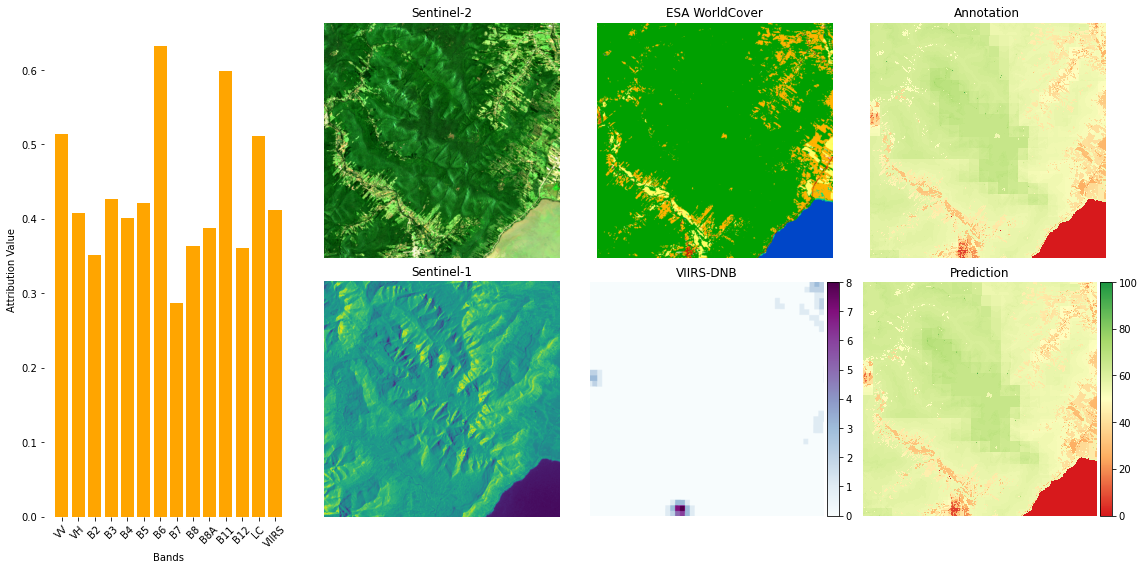

In [10]:
wdpa_id= 19428
im_place = test_dataset.ids.index(wdpa_id)
print(im_place)

viz_data = get_data(idx=im_place)
occ_vals = occ_reshap[im_place]
viz_bar_images(idx=wdpa_id, bar_vals=occ_vals, data=viz_data, save=True)